In [15]:
import shap
import joblib
import warnings
import pandas as pd
import seaborn as sns
from pdpbox import pdp
from sklearn.svm import SVC
from sklearn import set_config
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from utilities.evaluation import ModelEvaluation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

set_config(display='diagram')

pd.set_option('float_format', '{:.2f}'.format)
warnings.filterwarnings(action='ignore')

In [16]:
churn = pd.read_csv('../data/churn-modeling.csv', sep=';')
churn.sample(n=4)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2486,15745001,Kovalev,683,Spain,Female,36,7,0.00,2,Yes,No,104786.59,0
1910,15811261,Alaniz,617,Spain,Male,42,0,70105.87,1,Yes,Yes,120830.73,0
4189,15759499,Gardiner,598,France,Female,32,4,111156.52,1,Yes,Yes,167376.26,0
3099,15708196,Uchenna,696,Spain,Male,60,8,88786.81,1,Yes,Yes,196858.40,0


## Validación cruzada

In [17]:
exited = churn.pop('Exited')

train_data, test_data, train_label, test_label = train_test_split(churn, exited,
                                                                  test_size=0.3,
                                                                  stratify=exited, random_state=42)

print(f'El set de entrenamiento tiene {train_data.shape[0]} observaciones, y {train_data.shape[1]} variables.')
print(f'El set de prueba tiene {test_data.shape[0]} observaciones, y {test_data.shape[1]} variables.')

El set de entrenamiento tiene 7000 observaciones, y 12 variables.
El set de prueba tiene 3000 observaciones, y 12 variables.


In [18]:
numerical_features = ['CreditScore', 'Age', 'Tenure',
                      'Balance', 'NumOfProducts', 'EstimatedSalary']

categorical_features = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

In [19]:
numeric_preprocessing = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

categoric_preprocessing = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessing = ColumnTransformer(transformers=[('numeric', numeric_preprocessing, numerical_features),
                                                ('categorical', categoric_preprocessing, categorical_features)],
                                  remainder='drop')

In [20]:
lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(penalty='l1', solver='saga',
                                                                class_weight='balanced', random_state=42, n_jobs=-1))])

dtree = Pipeline(steps=[('preprocessing', preprocessing),
                        ('dtree', DecisionTreeClassifier(max_depth=4,
                                                         class_weight='balanced', random_state=42))])

svm = Pipeline(steps=[('preprocessing', preprocessing),
                      ('svm', SVC(probability=True,
                                  class_weight='balanced', random_state=42))])

In [21]:
roc = {}
f1_score = {}

roc['logistic_regression'] = cross_val_score(estimator=lr,
                                             X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)
roc['decision_tree'] = cross_val_score(estimator=dtree,
                                       X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)
roc['svm'] = cross_val_score(estimator=svm,
                             X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)

# --------------------------------------------------------------------------------------------------------------

f1_score['logistic_regression'] = cross_val_score(estimator=lr,
                                                  X=train_data, y=train_label, scoring='f1', cv=5, n_jobs=-1)
f1_score['decision_tree'] = cross_val_score(estimator=dtree,
                                            X=train_data, y=train_label, scoring='f1', cv=5, n_jobs=-1)
f1_score['svm'] = cross_val_score(estimator=svm,
                                  X=train_data, y=train_label, scoring='f1', cv=5, n_jobs=-1)

In [22]:
roc = pd.DataFrame.from_dict(roc)
f1_score = pd.DataFrame.from_dict(f1_score)

In [23]:
valor_medio = pd.concat(objs=[pd.DataFrame(roc.mean(), columns=['roc_auc']),
                              pd.DataFrame(f1_score.mean(), columns=['f1_score'])], axis=1)

In [24]:
std = pd.concat(objs=[pd.DataFrame(roc.std(), columns=['roc_auc_std']),
                      pd.DataFrame(f1_score.std(), columns=['f1_score_std'])], axis=1)

In [25]:
resultados = pd.concat(objs=[valor_medio, std], axis=1)
resultados

,roc_auc,f1_score,roc_auc_std,f1_score_std
logistic_regression,0.76,0.48,0.02,0.01
decision_tree,0.81,0.52,0.01,0.01
svm,0.85,0.58,0.01,0.01


In [33]:
lr.fit(train_data, train_label)
dtree.fit(train_data, train_label)
svm.fit(train_data, train_label)

predictions = {}

predictions['lr'] = cross_val_predict(estimator=lr,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method='predict_proba')[:, 1]

predictions['dtree'] = cross_val_predict(estimator=dtree,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method='predict_proba')[:, 1]

predictions['svm'] = cross_val_predict(estimator=svm,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method='predict_proba')[:, 1]

predictions = pd.DataFrame.from_dict(predictions)

In [34]:
predictions

,lr,dtree,svm
0,0.14,0.05,0.02
1,0.36,0.47,0.08
2,0.60,0.05,0.12
3,0.40,0.05,0.06
4,0.65,0.70,0.69
...,...,...,...
2995,0.93,0.67,0.30
2996,0.40,0.47,0.43
2997,0.69,0.27,0.56
2998,0.57,0.47,0.40


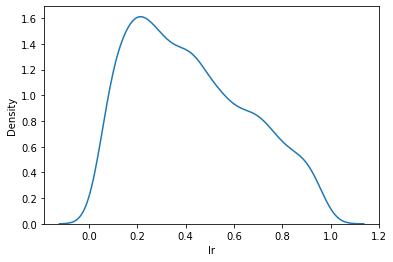

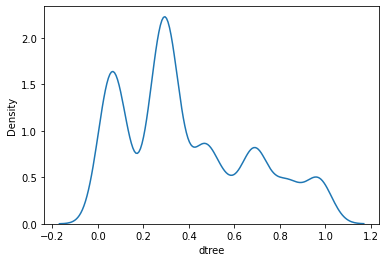

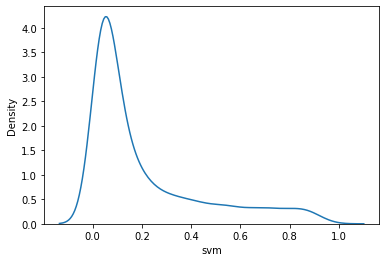

In [35]:
for col in predictions.columns:
    sns.distplot(predictions[col], hist=False)
    plt.show()

In [37]:
evaluation = ModelEvaluation(observed=test_label, predicted=svm.predict(test_data))
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix(normalize=False)

El AUC es: 0.79
El accuracy es: 0.8
La precision es: 0.84
El recall es: 0.8
El F1 Score es: 0.81 



Predicted,0,1
Observed,,
0,1921,468
1,141,470


In [42]:
svm['svm']

SVC(class_weight='balanced', probability=True, random_state=42)

In [40]:
params = svm['svm'].get_params()
params

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [44]:
joblib.dump(svm, filename='models/svm.joblib')
svm = None

In [46]:
svm = joblib.load(filename='models/svm.joblib')
svm

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Geography',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('svm',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [48]:
lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(penalty='l1', solver='saga',
                                                                class_weight='balanced', random_state=42, n_jobs=-1))])

dtree = Pipeline(steps=[('preprocessing', preprocessing),
                        ('dtree', DecisionTreeClassifier(max_depth=4,
                                                         class_weight='balanced', random_state=42))])

svm = Pipeline(steps=[('preprocessing', preprocessing),
                      ('svm', SVC(probability=True,
                                  class_weight='balanced', random_state=42))])

ensemble = VotingClassifier(estimators=[('lr', lr),
                                        ('dtree', dtree),
                                        ('svm', svm)],
                            weights=[1, 1, 2], voting='soft', n_jobs=-1)

ensemble.fit(train_data, train_label)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['CreditScore',
                                                                                 'Age',
                                                                                 'Tenure',
                                                                                 'Balance',
                                                                                 'NumOfProducts',
                                                                                 'EstimatedSalary']),
                                                                               ('categorical',
                                                                                Pipeline(steps=[('cat_imputer',
                                                                                                 SimpleImputer(strategy='mo...
                                                                                 'NumOfProducts',
                                                                                 'EstimatedSalary']),
                                                                               ('categorical',
                                                                                Pipeline(steps=[('cat_imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['Gender',
                                                                                 'Geography',
                                                                                 'HasCrCard',
                                                                                 'IsActiveMember'])])),
                                              ('svm',
                                               SVC(class_weight='balanced',
                                                   probability=True,
                                                   random_state=42))]))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 2])

In [49]:
evaluation = ModelEvaluation(observed=test_label, predicted=ensemble.predict(test_data))
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix(normalize=False)

El AUC es: 0.76
El accuracy es: 0.85
La precision es: 0.85
El recall es: 0.85
El F1 Score es: 0.85 



Predicted,0,1
Observed,,
0,2184,205
1,239,372
